# 🤪 Variational Autoencoders on CelebA Faces - Generate

In this notebook, we'll walk through the steps required to generate images using the autoencoder trained the CelebA faces dataset.

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Load the Model](#model)
3. [Reconstruct using the autoencoder](#reconstruct)
4. [Embed using the encoder](#encode)
5. [Generate using the decoder](#decode)
6. [Explore the latent space](#explore)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%html
<style>table {display: inline-block}</style>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory

from scipy.stats import norm
import pandas as pd

from utils.image import preprocess, noise, display
from utils.datasets import sample_batches, sample_batch
from utils.vae import get_vector_from_label, add_vector_to_images, morph_faces

## 0. Parameters <a name="parameters"></a>

In [8]:
IMAGE_SIZE = 128
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200

## 1. Prepare the data <a name="prepare"></a>

In [9]:
# Load the data
test_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba",
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.


In [10]:
# Preprocess the data
def preprocess(img):
    """
    Normalize the images
    """
    img = tf.cast(img, "float32") / 255.0
    return img


test = test_data.map(lambda x, y: (preprocess(x), y))

## 2. Load the model <a name="model"></a>

In [24]:
## Load the model trained in 01_train.ipynb
vae = load_model("./models/vae", compile=False)
encoder = load_model("./models/encoder", compile=False)
decoder = load_model("./models/decoder", compile=False)

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [25]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(list(test.take(batches_to_predict).get_single_element())[0])

Example real faces


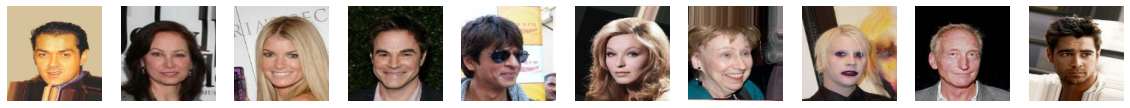

Reconstructions


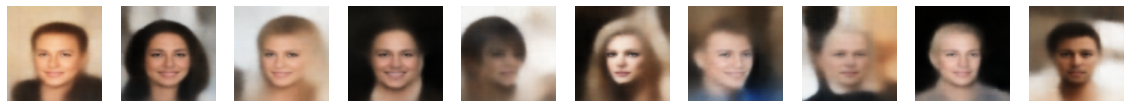

In [26]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

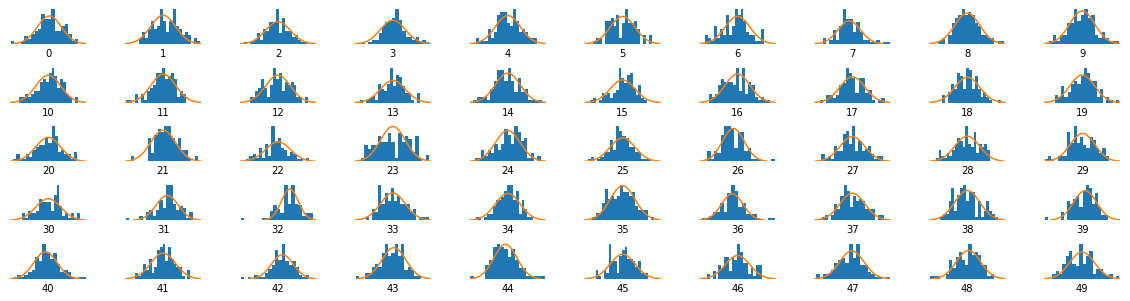

In [27]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [28]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, EMBEDDING_DIM))

In [29]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

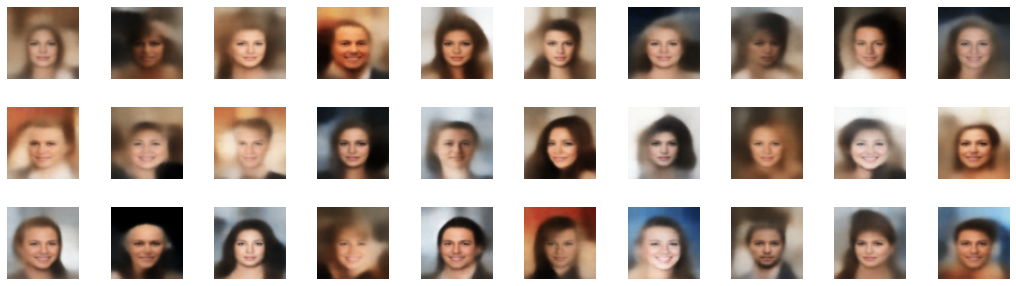

In [30]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [31]:
# Load the label dataset
attributes = pd.read_csv("/app/data/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [32]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [33]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, EMBEDDING_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
15    : 3.941    : 1.613    : 4.342    : 4.342
25    : 2.152    : 1.055    : 3.452    : -0.891
35    : 1.555    : 0.637    : 2.913    : -0.538
54    : 1.363    : 0.419    : 2.553    : -0.36
72    : 0.898    : 0.33    : 2.359    : -0.194
88    : 0.678    : 0.243    : 2.2    : -0.16
106    : 0.583    : 0.222    : 2.06    : -0.14
118    : 0.411    : 0.201    : 2.022    : -0.038
136    : 0.435    : 0.183    : 1.989    : -0.033
148    : 0.325    : 0.158    : 1.964    : -0.025
163    : 0.358    : 0.148    : 1.928    : -0.037
180    : 0.314    : 0.131    : 1.879    : -0.049
200    : 0.315    : 0.13    : 1.872    : -0.006
207    : 0.172    : 0.118    : 1.841    : -0.031
219    : 0.232    : 0.094    : 1.842    : 0.0
235    : 0.234    : 0.102    : 1.817    : -0.024
248    : 0.205    : 0.097    : 1.805    : -0.013
268    : 0.249    : 0.083    : 1.773    : -0.032
285    : 0.189    : 0.084    : 1.755    : -0.018
297    : 0.17    

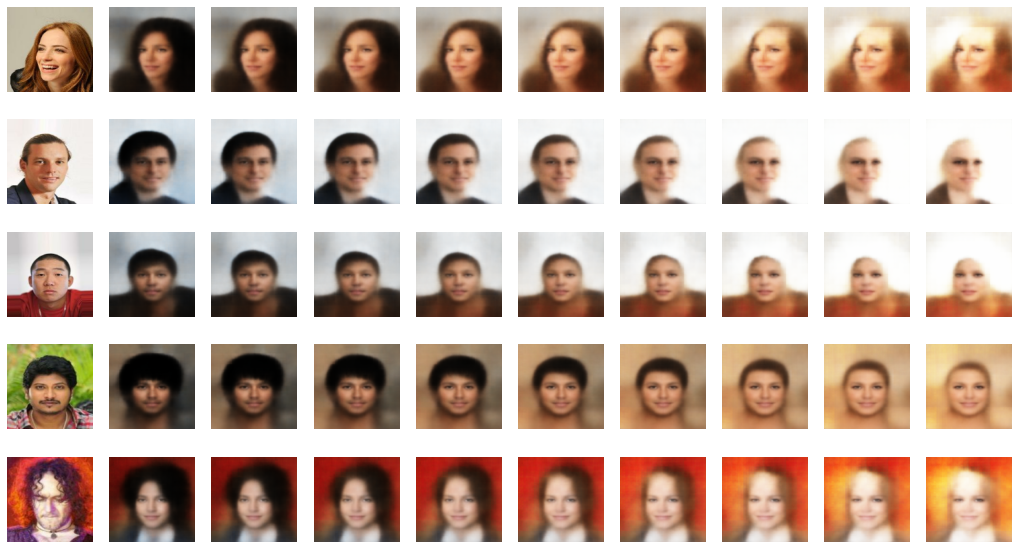

In [34]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

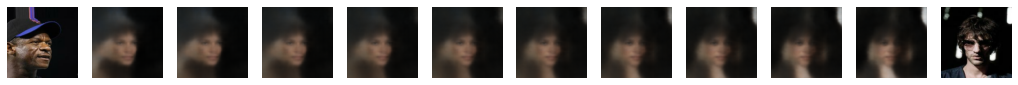

In [35]:
morph_faces(labelled, vae)